# Ground-Cover Classification Activity

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
#from osgeo import gdal

In [22]:
#landsat_2016_completo = gdal.Open('../data/img/landsat_2016.img').ReadAsArray()
sentinel = np.load('../data/rs/sentinel_small.npy') / 255

In [3]:
#landsat_2016_completo.shape

In [4]:
scale_by = .25
import scipy.misc
def scale_image(img, size):
    return np.array([scipy.misc.imresize(chan, size) for chan in img])

In [5]:
#landsat_2016 = scale_image(landsat_2016_completo, scale_by)

In [6]:
def show_image(img, ax=None):
    if len(img.shape) == 3:
        img = np.transpose(img, (1,2,0))
    if ax is None:
        plt.imshow(img, interpolation='nearest')
    else:
        ax.imshow(img, interpolation='nearest')

def show_rgb(red, green, blue, ax=None):
    show_image(np.array([red, green, blue]), ax=ax)

# Visualizar

<IPython.core.display.Javascript object>


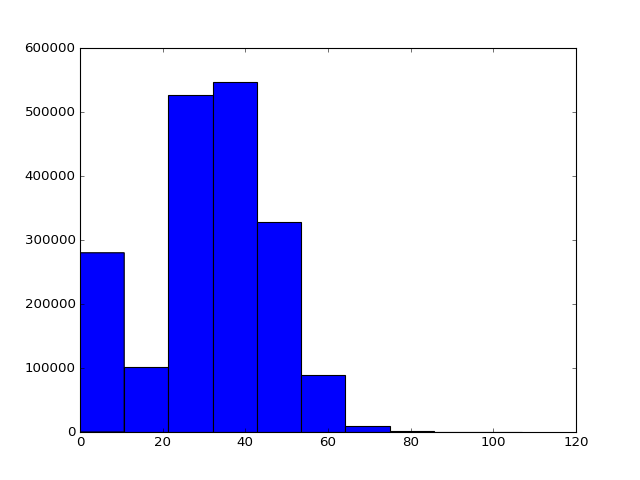

(array([  2.80073000e+05,   1.00917000e+05,   5.26344000e+05,
          5.46414000e+05,   3.27700000e+05,   8.90030000e+04,
          1.01240000e+04,   1.61400000e+03,   1.84000000e+02,
          1.10000000e+01]),
 array([   0. ,   10.7,   21.4,   32.1,   42.8,   53.5,   64.2,   74.9,
          85.6,   96.3,  107. ]),
 <a list of 10 Patch objects>)

In [13]:
plt.figure()
plt.hist(sentinel[11].ravel())

<IPython.core.display.Javascript object>


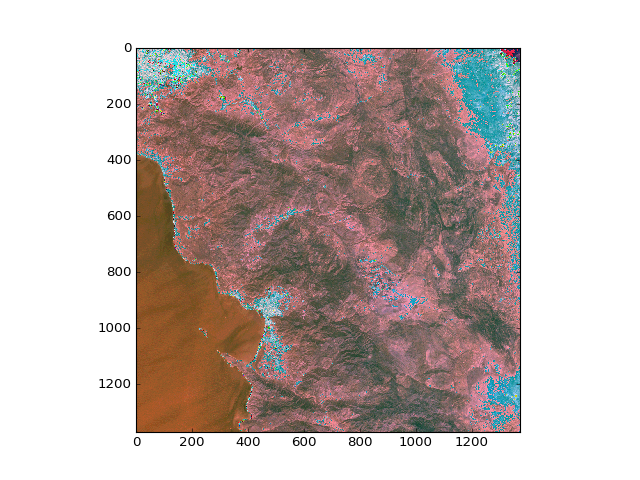

In [26]:
fig, axes = plt.subplots()
show_rgb(red=sentinel[0]*10, green=sentinel[1]*10, blue=sentinel[2]*10)

# Unsupervised clustering

In [27]:
import sklearn.cluster
cluster = sklearn.cluster.MiniBatchKMeans(n_clusters=12)
np.reshape(sentinel, (12, -1)).shape
clustered = cluster.fit_predict(np.reshape(sentinel, (12, -1)).T).reshape(sentinel.shape[1:])

/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1279: DeprecationWarning: This function is deprecated. Please call randint(0, 1882383 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 1882383 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 1882383 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 1882383 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randin

In [28]:
def show_img_and_classes(red, green, blue, classes):
    fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(13,5))
    show_rgb(red=red, green=green, blue=blue, ax=axs[0])
    axs[1].imshow(classes)

<IPython.core.display.Javascript object>


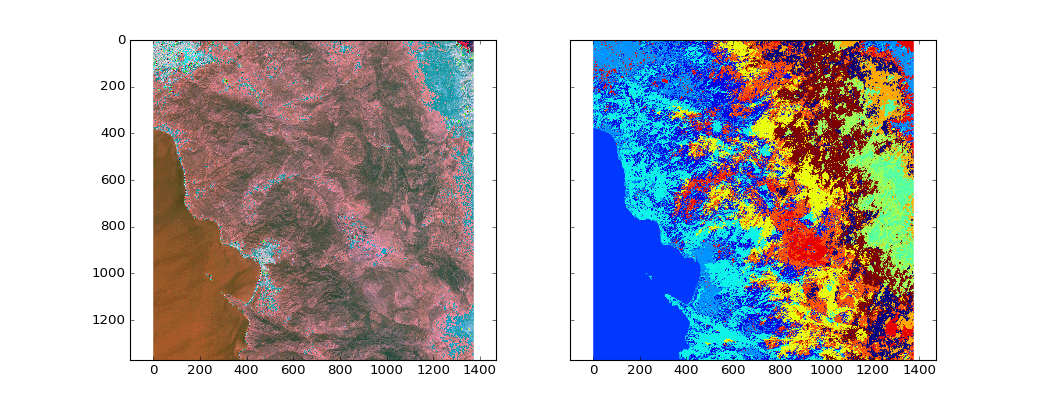

In [30]:
show_img_and_classes(red=sentinel[0]*10, green=sentinel[1]*10, blue=sentinel[2]*10, classes=clustered)

# Classification

In [ ]:
plt.figure()
plt.hist(landsat_2016_completo[0].ravel());

In [ ]:
veg = landsat_2016_completo[0] > 100
show_img_and_classes(red=landsat_2016[0], green=landsat_2016[1], blue=landsat_2016[2], classes=veg)